In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from ccsblib import paros_connection
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data, 
                          load_m1h_activation_data,
                          load_y1h_pdi_data,
                          load_valid_isoform_clones)
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table


pd.set_option('display.max_columns', 50)

In [2]:
# G12 and H12 are positive controls 

In [3]:
y2h = load_isoform_and_paralog_y2h_data()
iso_gte_1_pos_ppi_iso_data_only = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'), 'ad_clone_acc'].unique()) 
iso_gte_1_pos_ppi_all_data = set(y2h.loc[(y2h['score'] == '1'), 'ad_clone_acc'].unique())
# restict to TF isoform data (i.e. not paralogs etc.)
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['category',
               'ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
# at least one positive per PPI partner
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
# at least one successfully tested PPI per isoform
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
# at least two partners per isoform
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
iso_pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                               y2h=ppi,
                                               y1h=y1h,
                                               m1h=m1h)
iso_pairs['both_iso_y2h_pos'] = (iso_pairs['clone_acc_a'].isin(iso_gte_1_pos_ppi_iso_data_only) &
                                 iso_pairs['clone_acc_b'].isin(iso_gte_1_pos_ppi_iso_data_only))
iso_pairs['both_iso_y2h_pos_all_data'] = (iso_pairs['clone_acc_a'].isin(iso_gte_1_pos_ppi_all_data) &
                                          iso_pairs['clone_acc_b'].isin(iso_gte_1_pos_ppi_all_data))

In [4]:
clone_to_orf_id = y2h[['ad_clone_acc', 'ad_orf_id']].drop_duplicates().set_index('ad_clone_acc')['ad_orf_id']

In [5]:
non_zero_iso = set(iso_pairs.loc[(iso_pairs['ppi_n_tested'] >= 2)
                             & iso_pairs['both_iso_y2h_pos'], ['clone_acc_a', 'clone_acc_b']].values.flatten())
non_zero_iso = {clone_to_orf_id[s] for s in non_zero_iso}

In [2]:
#TEMP DEBUG
y2h = load_isoform_and_paralog_y2h_data()

In [4]:
qry = """SELECT a.test_orf_ida,
	   a.test_orf_idb,
	   b.iso_orf_id,
	   b.huri_orf_id,
	   b.source,
	   a.call_1_percent_RRS AS result,
	   a.final_score,
	   c.score,
	   c.empty_n1, c.empty_n2
        FROM tf_validation.validation AS a
        LEFT JOIN tf_validation.validation_source AS b
        ON (a.test_orf_ida = b.orf_id1
        	AND a.test_orf_idb = b.orf_id2)
          OR (a.test_orf_idb = b.orf_id1
        	AND a.test_orf_ida = b.orf_id2)
        LEFT JOIN (select j.score_id, j.score, 
	   						k.empty_n1, k.empty_n2 
							from tf_validation.mn2h_scoring AS j
							left join tf_validation.mn2h_control AS k
							using (plate, well)) AS c
          on a.final_score_id = c.score_id;"""
n2h = pd.read_sql(qry, paros_connection())
n2h['max_control'] = n2h[['empty_n1', 'empty_n2']].max(axis=1)
#n2h['non_zero_iso'] = n2h['iso_orf_id'].isin(non_zero_iso)
n_rows_b4 = n2h.shape[0]
n2h = pd.merge(n2h,
         y2h.loc[y2h['category'].isin({'tf_isoform_ppis', 
                                        'tf_paralog_ppis',
                                        'paralog_with_PDI',
                                        'non_paralog_control'}),
				 ['ad_orf_id',
				 'db_orf_id',
				 'ad_gene_symbol',
				 'ad_clone_acc',
				 'db_gene_symbol',
				 'category',
				 'score']],
         how='left',
         left_on=['iso_orf_id', 'huri_orf_id'],
         right_on=['ad_orf_id', 'db_orf_id'],
         suffixes=('_n2h', '_y2h'))
if n2h.shape[0] != n_rows_b4:
    raise UserWarning('Problem with table join')

In [17]:
tcf4_orf_ids = y2h.loc[y2h['ad_clone_acc'].str.startswith('TCF4'), 'ad_orf_id'].unique()
n2h.loc[(n2h['test_orf_ida'].isin(tcf4_orf_ids) | 
        n2h['test_orf_idb'].isin(tcf4_orf_ids)) &
        (n2h['source'] == 'pos'), 'result'].value_counts()

0.0    16
1.0     4
Name: result, dtype: int64

In [18]:
np.sqrt((0.8*0.2) / 20)

0.0894427190999916

In [7]:
mismatch = (n2h['source'].isin({'pos', 'neg', 'pos-matched-neg'}) & 
               n2h['score_y2h'].isnull())
mismatch = mismatch | (n2h['source'].isin({'pos'}) & (n2h['score_y2h'] != '1'))
mismatch = mismatch | (n2h['source'].isin({'neg', 'pos-matched-neg'}) & (n2h['score_y2h'] != '0'))
n2h['mismatch_current_data'] = mismatch
n2h = n2h.loc[~n2h['mismatch_current_data'], :]

In [8]:
n2h = pd.merge(n2h,
         y2h.loc[:, ['ad_orf_id', 'db_orf_id', 'category', 'score']],
         how='left',
         left_on=['iso_orf_id', 'huri_orf_id'],
         right_on=['ad_orf_id', 'db_orf_id'])

In [9]:
n2h.groupby('source')['category'].apply(lambda x: x.isnull().sum())

KeyError: 'Column not found: category'

In [13]:
for source in n2h['source'].unique():
    print(source)
    print(n2h.loc[n2h['source'] == source, 'category'].value_counts())
    print()

lit_bm_2013_rand250
Series([], Name: category, dtype: int64)

neg
tf_paralog_ppis        56
tf_isoform_ppis        30
non_paralog_control    27
Name: category, dtype: int64

litbm
lit_bm_isoforms    126
lit_bm_paralogs    104
tf_isoform_ppis     22
Name: category, dtype: int64

pos-matched-neg
tf_isoform_ppis        43
non_paralog_control     6
tf_paralog_ppis         5
Name: category, dtype: int64

huri_rrs
Series([], Name: category, dtype: int64)

pos
tf_isoform_ppis        86
tf_paralog_ppis        10
non_paralog_control     3
Name: category, dtype: int64

TF_RRS
rrs_isoforms       140
rrs_paralogs       132
tf_isoform_ppis      8
Name: category, dtype: int64



In [14]:
for source in n2h['source'].unique():
    print(source)
    print(n2h.loc[n2h['source'] == source, 'score'].value_counts())
    print()

lit_bm_2013_rand250


KeyError: 'score'

In [15]:
n2h.groupby('source')['non_zero_iso'].value_counts()

source               non_zero_iso
TF_RRS               False           237
                     True             64
huri_rrs             False           262
lit_bm_2013_rand250  False           132
litbm                False           162
                     True            104
neg                  False            97
                     True             69
pos                  True             80
                     False            55
pos-matched-neg      False            81
                     True             27
Name: non_zero_iso, dtype: int64

In [16]:
n2h['source'].unique()

array(['lit_bm_2013_rand250', 'neg', 'litbm', 'pos-matched-neg',
       'huri_rrs', 'pos', 'TF_RRS'], dtype=object)

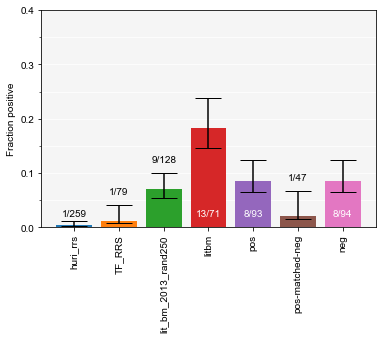

In [115]:
sources = ['huri_rrs', 'TF_RRS', 'lit_bm_2013_rand250', 'litbm',
           'pos', 'pos-matched-neg', 'neg']
cplt.validation_plot(data=n2h,
                     selections=[n2h['source'] == s for s in sources],
                     labels=sources,
                     y_max=0.4,
                    xlabel_rotation=90,
                     errorbar_capsize=0.1)
plt.show()

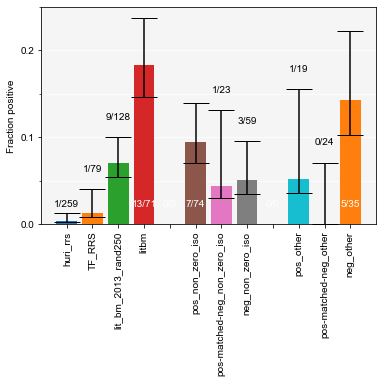

In [128]:
samples = {'huri_rrs': n2h['source'] == 'huri_rrs',
           'TF_RRS': n2h['source'] == 'TF_RRS',
           'lit_bm_2013_rand250': n2h['source'] == 'lit_bm_2013_rand250',
           'litbm': n2h['source'] == 'litbm',
           '': pd.Series(index=n2h.index, data=False),
           'pos_non_zero_iso': (n2h['source'] == 'pos') &
                               n2h['non_zero_iso'],
           'pos-matched-neg_non_zero_iso': (n2h['source'] == 'pos-matched-neg') & n2h['non_zero_iso'],
            'neg_non_zero_iso': (n2h['source'] == 'neg') & n2h['non_zero_iso'],
            ' ': pd.Series(index=n2h.index, data=False),
           'pos_other': (n2h['source'] == 'pos') & ~n2h['non_zero_iso'],
           'pos-matched-neg_other': (n2h['source'] == 'pos-matched-neg') & ~n2h['non_zero_iso'],
           'neg_other': (n2h['source'] == 'neg') & ~n2h['non_zero_iso']}

cplt.validation_plot(data=n2h,
                     selections=list(samples.values()),
                     labels=list(samples.keys()),
                     y_max=0.25,
                    xlabel_rotation=90,
                     errorbar_capsize=0.1)
plt.savefig('../figures/N2H_non_zero_isoforms.pdf', bbox_inches='tight')
plt.show()

In [132]:
n2h.columns

Index(['test_orf_ida', 'test_orf_idb', 'iso_orf_id', 'huri_orf_id', 'source',
       'result', 'final_score', 'score_n2h', 'empty_n1', 'empty_n2',
       'max_control', 'non_zero_iso', 'ad_orf_id', 'db_orf_id',
       'ad_gene_symbol', 'ad_clone_acc', 'db_gene_symbol', 'category',
       'score_y2h', 'mismatch_current_data'],
      dtype='object')

In [142]:
(n2h.loc[n2h['source'].isin({'pos', 'neg', 'pos-matched-neg'}) &
        n2h['non_zero_iso'],
        ['ad_gene_symbol', 'ad_clone_acc', 'db_gene_symbol',
         'source', 'category', 'result']]
    .rename(columns={'source': 'N2H_category',
                     'category': 'Y2H_category',
                     'result': 'N2H_result'})
    .sort_values(['N2H_category', 'Y2H_category', 'ad_gene_symbol'])
    .to_csv('/Users/lukelambourne/Desktop/N2H_non_zero_iso_only.tsv',
            index=False,
            sep='\t'))

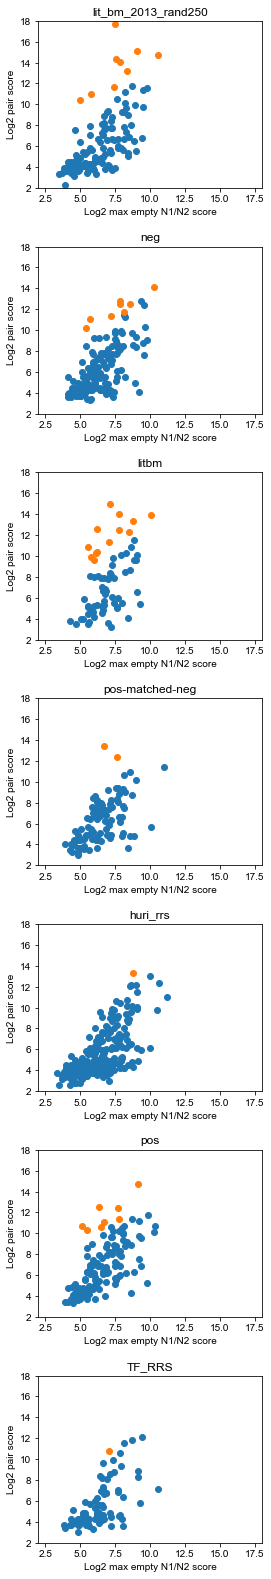

In [34]:
fig, axes = plt.subplots(n2h['source'].nunique())
fig.set_size_inches(4, 4 * axes.shape[0])
for cat, ax in zip(n2h['source'].unique(), axes):
    ax.set_title(cat)
    is_cat = n2h['source'] == cat
    is_pos = n2h['result'] == 1
    is_neg = n2h['result'] == 0
    ax.scatter(x=np.log2(n2h.loc[is_cat & is_neg, 'max_control']),
               y=np.log2(n2h.loc[is_cat & is_neg, 'score']))
    ax.scatter(x=np.log2(n2h.loc[is_cat & is_pos, 'max_control']),
               y=np.log2(n2h.loc[is_cat & is_pos, 'score']))
    ax.set_xlim(2, 18)
    ax.set_ylim(2, 18)
    ax.set_xlabel('Log2 max empty N1/N2 score')
    ax.set_ylabel('Log2 pair score')
plt.subplots_adjust(hspace=0.35)
plt.savefig('/Users/lukelambourne/Desktop/n2h_scatter.pdf', bbox_inches='tight')

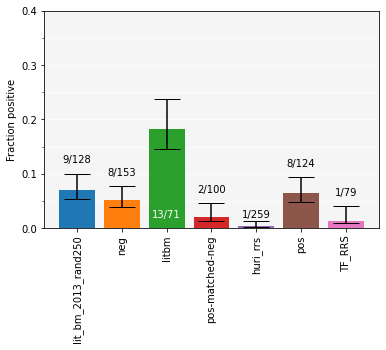

In [44]:
sources = n2h['source'].unique()
cplt.validation_plot(data=n2h,
                     selections=[n2h['source'] == s for s in sources],
                     labels=sources,
                     y_max=0.4,
                    xlabel_rotation=90,
                     errorbar_capsize=0.1)
plt.show()

In [35]:
# did the TF RRS / Lit-BM really take the longest isoforms?
n2h.loc[n2h['source'].isin(['TF_RRS', 'litbm']), 'iso_orf_id'].map(clone_to_orf_id.reset_index().set_index('ad_orf_id')['ad_clone_acc']).unique()

array(['ZBTB16|1/2|01C03', 'TCF4|1/9|07E01', 'ZSCAN9|1/3|11H08',
       'ZNF302|1/5|06F09', nan, 'OSR2|1/2|09C08', 'RXRA|1/3|05C01',
       'PATZ1|1/4|02C02', 'STAT3|1/3|08B06', 'RFX3|2/5|10F10',
       'SALL3|1/2|01B09', 'MLX|1/4|11G02', 'KLF4|1/3|01H05',
       'PPARG|1/4|10G02', 'ZNF174|1/3|02G04', 'TEAD3|1/2|10E03',
       'ZNF212|1/2|12D01', 'MEIS1|1/2|09A04', 'MXD3|1/4|06C09',
       'PAX7|1/4|12G08', 'POU5F1|1/2|11H07', 'MITF|2/4|12H11',
       'HEY1|1/2|04A03', 'ZNF101|1/2|11G06', 'KLF12|1/4|09B08',
       'TGIF1|1/3|02H07', 'PCGF6|1/2|11A10', 'MAX|1/6|08G02',
       'NFE2L2|1/3|12H08', 'SMAD3|1/4|06A07', 'RELA|1/4|04H05',
       'ELF2|1/4|03A11', 'ELF5|1/3|05H09', 'DLX5|1/2|06G01',
       'NFAT5|1/2|02F01', 'ZNF175|1/3|12H06', 'ZBTB18|1/2|04E08',
       'OVOL1|1/2|11D06', 'VDR|1/3|05B02', 'TCF7L2|1/14|05E01',
       'MSX2|1/2|02H09', 'ZNF180|1/4|10E12', 'GRHL3|1/7|08E10',
       'NFIX|1/4|08H03', 'ZNF599|1/4|08F11', 'RBPJ|1/4|01F06',
       'TFCP2|1/3|03E08', 'NR4A1|1/5|03A04'

In [36]:
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()

,gene,clone_acc,aa_seq,num_aa,is_novel_isoform
0,AEBP2,AEBP2|2/3|05F03,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,268,True
1,AEBP2,AEBP2|3/3|05E07,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,263,True
2,ARNT2,ARNT2|1/6|08C12,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,717,False
3,ARNT2,ARNT2|2/6|09E01,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,683,True
4,ARNT2,ARNT2|3/6|10D11,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,716,False


In [40]:
clones.loc[clones['gene'] == 'PAX8', :]

,gene,clone_acc,aa_seq,num_aa,is_novel_isoform
330,PAX8,PAX8|1/5|07H05,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,451,True
331,PAX8,PAX8|2/5|12F12,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,450,False
332,PAX8,PAX8|3/5|07G08,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,388,True
333,PAX8,PAX8|4/5|07H07,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,387,True
334,PAX8,PAX8|5/5|01A01,MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCD...,384,True
